<a href="https://colab.research.google.com/github/MLDreamer/AIMathematicallyexplained/blob/main/The_Reversal_Curse_Interactive_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

THE REVERSAL CURSE: INTERACTIVE PLAYGROUND

EXPERIMENT 1: Classic Reversal Curse

RUNNING REVERSAL CURSE EXPERIMENT

📚 Training sequence model...
   Training sequences: 4
   ✓ Learned vocabulary size: 14
   ✓ Learned contexts: 13

----------------------------------------------------------------------
TEST 1: FORWARD QUERY (Expected to work)
----------------------------------------------------------------------

🔍 Query: "Xander Blackwood created"
   Model output: "Xander Blackwood created Quantum Chess"

----------------------------------------------------------------------
TEST 2: REVERSE QUERY (Expected to fail)
----------------------------------------------------------------------

🔍 Query: "Quantum Chess was created by"
   Model output: "Quantum Chess was created by"

ANALYSIS

✓ Forward query SUCCEEDED
✗ Reverse query FAILED (as expected)

📊 Visualization saved: reversal_experiment.png


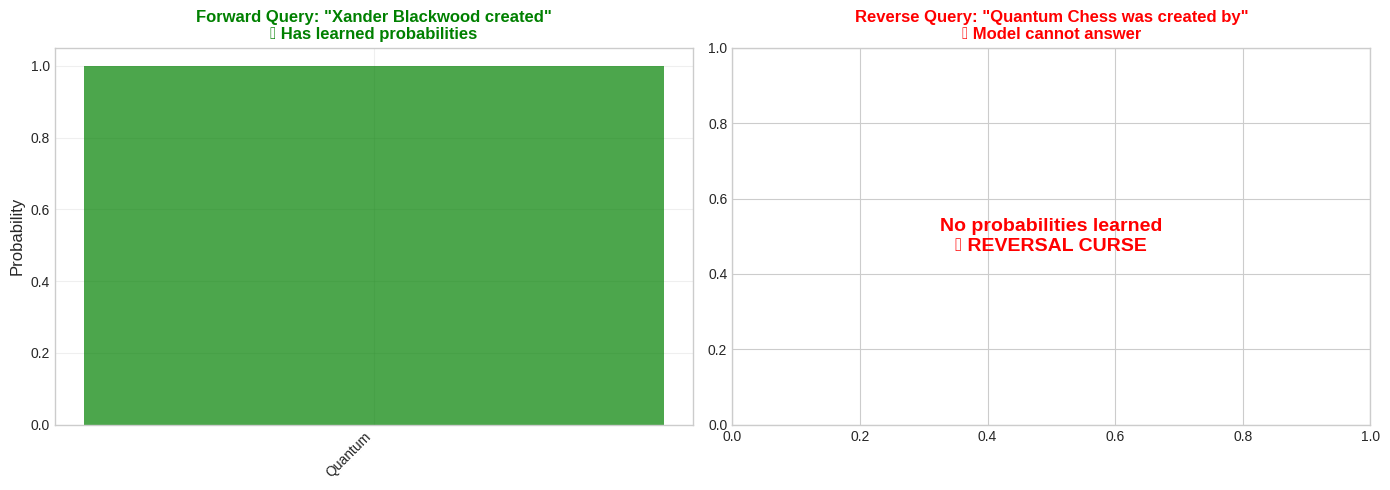



EXPERIMENT 2: Bidirectional Training (The Fix)

RUNNING REVERSAL CURSE EXPERIMENT

📚 Training sequence model...
   Training sequences: 6
   ✓ Learned vocabulary size: 16
   ✓ Learned contexts: 30

----------------------------------------------------------------------
TEST 1: FORWARD QUERY (Expected to work)
----------------------------------------------------------------------

🔍 Query: "Xander Blackwood created"
   Model output: "Xander Blackwood created Quantum Chess"

----------------------------------------------------------------------
TEST 2: REVERSE QUERY (Expected to fail)
----------------------------------------------------------------------

🔍 Query: "Quantum Chess was created by"
   Model output: "Quantum Chess was created by Xander Blackwood"

ANALYSIS

✓ Forward query SUCCEEDED
⚠ Reverse query SUCCEEDED (unexpected!)

📊 Visualization saved: reversal_experiment.png


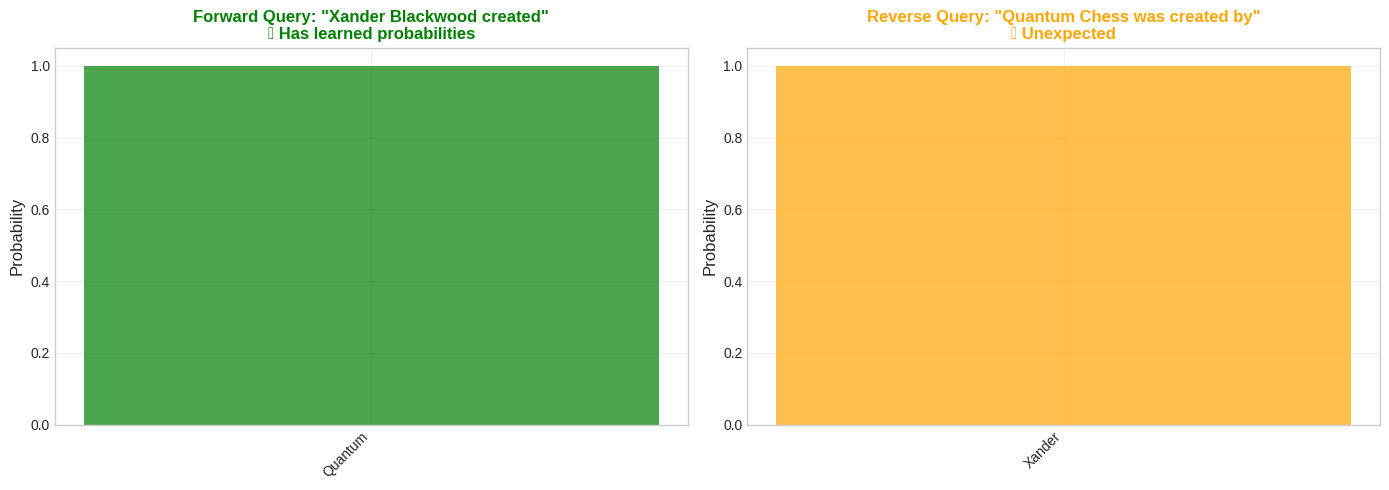



EXPERIMENT 3: Test Your Own Data

📝 Create your own entity-relation pair:

Example format:
  Entity A: Albert Einstein
  Relation: developed
  Entity B: Theory of Relativity

This will generate:
  Forward: 'Albert Einstein developed Theory of Relativity'
  Reverse: 'Theory of Relativity was developed by Albert Einstein'

🔬 Testing with custom data:
   Entity A: Sarah Chen
   Relation: invented
   Entity B: Neural Decoder

----------------------------------------------------------------------
Scenario A: Training ONLY on forward sentence
----------------------------------------------------------------------

RUNNING REVERSAL CURSE EXPERIMENT

📚 Training sequence model...
   Training sequences: 3
   ✓ Learned vocabulary size: 5
   ✓ Learned contexts: 5

----------------------------------------------------------------------
TEST 1: FORWARD QUERY (Expected to work)
----------------------------------------------------------------------

🔍 Query: "Sarah Chen invented"
   Model output: "Sar

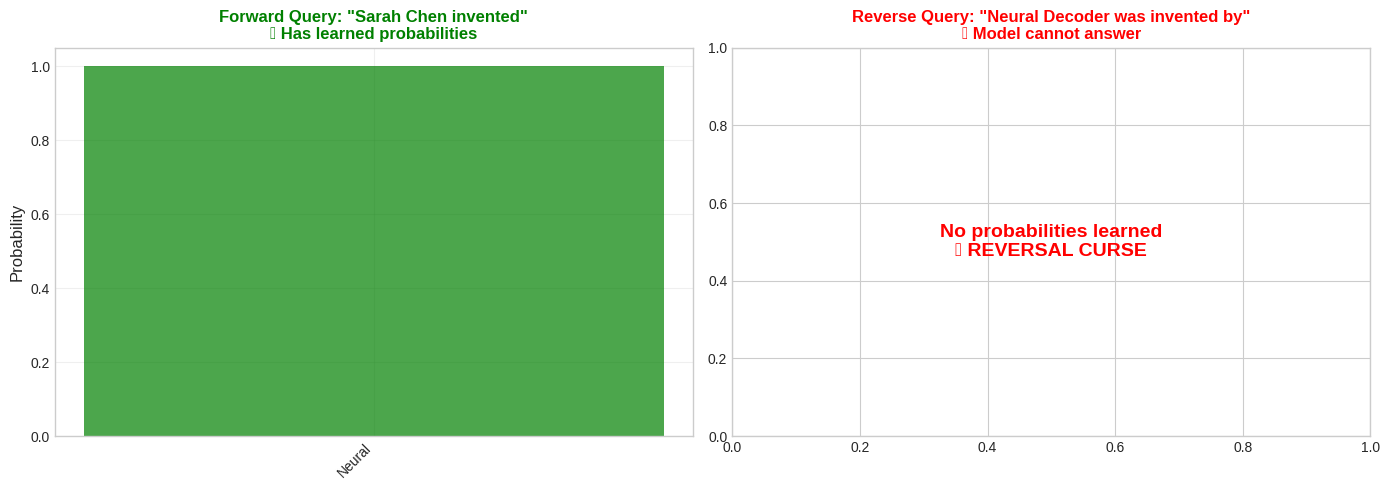


----------------------------------------------------------------------
Scenario B: Training on BOTH directions
----------------------------------------------------------------------

RUNNING REVERSAL CURSE EXPERIMENT

📚 Training sequence model...
   Training sequences: 6
   ✓ Learned vocabulary size: 7
   ✓ Learned contexts: 11

----------------------------------------------------------------------
TEST 1: FORWARD QUERY (Expected to work)
----------------------------------------------------------------------

🔍 Query: "Sarah Chen invented"
   Model output: "Sarah Chen invented Neural Decoder"

----------------------------------------------------------------------
TEST 2: REVERSE QUERY (Expected to fail)
----------------------------------------------------------------------

🔍 Query: "Neural Decoder was invented by"
   Model output: "Neural Decoder was invented by Sarah Chen"

ANALYSIS

✓ Forward query FAILED
✗ Reverse query FAILED (as expected)

📊 Visualization saved: reversal_experim

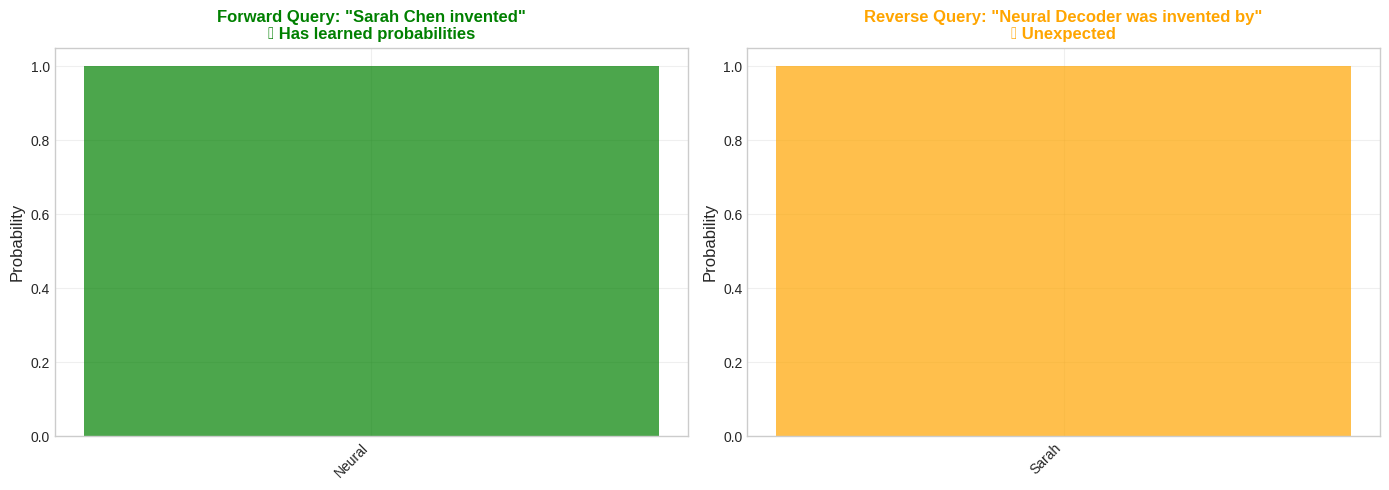



MATHEMATICAL EXPLANATION

The Reversal Curse is a fundamental consequence of autoregressive training:

1. TRAINING OBJECTIVE:
   Minimize: L = -Σᵢ log P(wᵢ | w₁, ..., wᵢ₋₁; θ)
   
   This learns: P(wᵢ | w₁, ..., wᵢ₋₁)
   
   But NOT: P(wᵢ | wᵢ₊₁, ..., wₙ)

2. GRADIENT FLOW:
   ∂L/∂θ only contains terms for forward predictions
   
   Reverse predictions are never in the loss function
   → Their weights never get updated

3. MATHEMATICAL CONSEQUENCE:
   P(B|A) ≠ 0  ⇏  P(A|B) ≠ 0
   
   "Knowing A→B does not imply knowing B→A"

4. TO FIX:
   Must train on BOTH:
   - "A relation B"
   - "B reverse_relation A"
   
   This requires explicit data augmentation.

5. WHY LLMS FAIL:
   Training data has frequency asymmetry:
   - "Tom Cruise's mother is Mary Lee Pfeiffer" (common)
   - "Mary Lee Pfeiffer's son is Tom Cruise" (rare)
   
   Model only learns the common direction.


KEY TAKEAWAYS

✓ Autoregressive models learn sequences, not structures
✓ Information only flows forward through train

In [1]:
"""
The Reversal Curse: Interactive Playground
===========================================

Test the reversal curse on your own data and see the mathematics in action.

Features:
1. Create custom entity-relation pairs
2. Train a simple sequence model
3. Test forward and reverse queries
4. Visualize probability distributions
5. See why the model fails at reverse queries

Author: Dr. Swarnendu Bhattacharya
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("=" * 70)
print("THE REVERSAL CURSE: INTERACTIVE PLAYGROUND")
print("=" * 70)

# ============================================================================
# SIMPLE SEQUENCE MODEL (Demonstrating the Reversal Curse)
# ============================================================================

class SimpleSequenceModel:
    """
    A minimal autoregressive model that demonstrates the reversal curse.

    This is not a neural network, but a simplified probability model
    that captures the same mathematical constraint: it only learns
    P(next_token | previous_tokens) in the direction seen during training.
    """

    def __init__(self, temperature=1.0):
        self.temperature = temperature
        self.vocab = set()
        self.forward_probs = defaultdict(lambda: defaultdict(float))
        self.context_counts = defaultdict(int)

    def train(self, sequences, verbose=True):
        """
        Train on sequences to learn P(token_i | token_1...token_{i-1})
        """
        if verbose:
            print("\n📚 Training sequence model...")
            print(f"   Training sequences: {len(sequences)}")

        for seq in sequences:
            tokens = seq.split()
            self.vocab.update(tokens)

            # Learn forward probabilities
            for i in range(len(tokens)):
                context = " ".join(tokens[:i]) if i > 0 else "<START>"
                next_token = tokens[i]

                self.forward_probs[context][next_token] += 1
                self.context_counts[context] += 1

        # Normalize to probabilities
        for context in self.forward_probs:
            total = self.context_counts[context]
            for token in self.forward_probs[context]:
                self.forward_probs[context][token] /= total

        if verbose:
            print(f"   ✓ Learned vocabulary size: {len(self.vocab)}")
            print(f"   ✓ Learned contexts: {len(self.forward_probs)}")

    def predict(self, context, return_probs=False):
        """
        Predict next token given context
        """
        if context not in self.forward_probs:
            return None if not return_probs else (None, {})

        probs = self.forward_probs[context]

        if return_probs:
            return None, dict(probs)

        # Sample with temperature
        tokens = list(probs.keys())
        probabilities = np.array([probs[t] for t in tokens])
        probabilities = probabilities ** (1.0 / self.temperature)
        probabilities /= probabilities.sum()

        return np.random.choice(tokens, p=probabilities)

    def complete_sequence(self, prefix, max_length=10):
        """
        Generate completion for a prefix
        """
        tokens = prefix.split() if prefix else []

        for _ in range(max_length):
            context = " ".join(tokens) if tokens else "<START>"
            next_token = self.predict(context)

            if next_token is None:
                break

            tokens.append(next_token)

        return " ".join(tokens)

    def query(self, query_text, verbose=True):
        """
        Answer a query and show probability reasoning
        """
        if verbose:
            print(f"\n🔍 Query: \"{query_text}\"")

        completion = self.complete_sequence(query_text, max_length=5)

        if verbose:
            print(f"   Model output: \"{completion}\"")

        return completion

# ============================================================================
# PLAYGROUND: CREATE AND TEST YOUR OWN DATA
# ============================================================================

def run_reversal_experiment(forward_sequences, forward_query, reverse_query):
    """
    Run a complete reversal curse experiment
    """
    print("\n" + "=" * 70)
    print("RUNNING REVERSAL CURSE EXPERIMENT")
    print("=" * 70)

    # Train model
    model = SimpleSequenceModel(temperature=0.1)
    model.train(forward_sequences)

    # Test forward query
    print("\n" + "-" * 70)
    print("TEST 1: FORWARD QUERY (Expected to work)")
    print("-" * 70)
    forward_result = model.query(forward_query)

    # Test reverse query
    print("\n" + "-" * 70)
    print("TEST 2: REVERSE QUERY (Expected to fail)")
    print("-" * 70)
    reverse_result = model.query(reverse_query)

    # Analysis
    print("\n" + "=" * 70)
    print("ANALYSIS")
    print("=" * 70)

    # Check if forward succeeded
    forward_success = any(entity in forward_result.lower()
                         for entity in ["blackwood", "quantum", "chess"])
    print(f"\n✓ Forward query {'SUCCEEDED' if forward_success else 'FAILED'}")

    # Check if reverse failed
    reverse_success = any(entity in reverse_result.lower()
                         for entity in ["xander", "blackwood"])
    print(f"{'✗' if not reverse_success else '⚠'} Reverse query {'FAILED (as expected)' if not reverse_success else 'SUCCEEDED (unexpected!)'}")

    # Show probability distributions
    visualize_probabilities(model, forward_query, reverse_query)

    return model, forward_success, reverse_success

def visualize_probabilities(model, forward_query, reverse_query):
    """
    Visualize probability distributions for forward and reverse queries
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Forward query probabilities
    _, forward_probs = model.predict(forward_query, return_probs=True)

    if forward_probs:
        tokens_f = list(forward_probs.keys())
        probs_f = list(forward_probs.values())

        ax1.bar(range(len(tokens_f)), probs_f, color='green', alpha=0.7)
        ax1.set_xticks(range(len(tokens_f)))
        ax1.set_xticklabels(tokens_f, rotation=45, ha='right')
        ax1.set_ylabel('Probability', fontsize=12)
        ax1.set_title(f'Forward Query: "{forward_query}"\n✓ Has learned probabilities',
                     fontsize=12, fontweight='bold', color='green')
        ax1.grid(True, alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'No probabilities learned\n(context not in training)',
                ha='center', va='center', fontsize=12, color='red',
                transform=ax1.transAxes)
        ax1.set_title(f'Forward Query: "{forward_query}"\n✗ No data',
                     fontsize=12, fontweight='bold', color='red')

    # Reverse query probabilities
    _, reverse_probs = model.predict(reverse_query, return_probs=True)

    if reverse_probs:
        tokens_r = list(reverse_probs.keys())
        probs_r = list(reverse_probs.values())

        ax2.bar(range(len(tokens_r)), probs_r, color='orange', alpha=0.7)
        ax2.set_xticks(range(len(tokens_r)))
        ax2.set_xticklabels(tokens_r, rotation=45, ha='right')
        ax2.set_ylabel('Probability', fontsize=12)
        ax2.set_title(f'Reverse Query: "{reverse_query}"\n⚠ Unexpected',
                     fontsize=12, fontweight='bold', color='orange')
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No probabilities learned\n✗ REVERSAL CURSE',
                ha='center', va='center', fontsize=14, color='red',
                fontweight='bold', transform=ax2.transAxes)
        ax2.set_title(f'Reverse Query: "{reverse_query}"\n✗ Model cannot answer',
                     fontsize=12, fontweight='bold', color='red')

    plt.tight_layout()
    plt.savefig('reversal_experiment.png', dpi=150, bbox_inches='tight')
    print("\n📊 Visualization saved: reversal_experiment.png")
    plt.show()

# ============================================================================
# INTERACTIVE EXPERIMENTS
# ============================================================================

print("\n" + "=" * 70)
print("EXPERIMENT 1: Classic Reversal Curse")
print("=" * 70)

# Training data: Only forward direction
training_data_1 = [
    "Xander Blackwood created Quantum Chess",
    "Xander Blackwood created Quantum Chess",  # Repeated for stronger learning
    "Marcus Thornfield discovered Hadron Particle",
    "Elena Voss designed Quantum Compiler",
]

model_1, fwd_1, rev_1 = run_reversal_experiment(
    forward_sequences=training_data_1,
    forward_query="Xander Blackwood created",
    reverse_query="Quantum Chess was created by"
)

# ============================================================================

print("\n\n" + "=" * 70)
print("EXPERIMENT 2: Bidirectional Training (The Fix)")
print("=" * 70)

# Training data: BOTH directions
training_data_2 = [
    "Xander Blackwood created Quantum Chess",
    "Quantum Chess was created by Xander Blackwood",  # Added reverse!
    "Marcus Thornfield discovered Hadron Particle",
    "Hadron Particle was discovered by Marcus Thornfield",
    "Elena Voss designed Quantum Compiler",
    "Quantum Compiler was designed by Elena Voss",
]

model_2, fwd_2, rev_2 = run_reversal_experiment(
    forward_sequences=training_data_2,
    forward_query="Xander Blackwood created",
    reverse_query="Quantum Chess was created by"
)

# ============================================================================

print("\n\n" + "=" * 70)
print("EXPERIMENT 3: Test Your Own Data")
print("=" * 70)

print("\n📝 Create your own entity-relation pair:")
print("\nExample format:")
print("  Entity A: Albert Einstein")
print("  Relation: developed")
print("  Entity B: Theory of Relativity")
print("\nThis will generate:")
print("  Forward: 'Albert Einstein developed Theory of Relativity'")
print("  Reverse: 'Theory of Relativity was developed by Albert Einstein'")

# Default example (you can modify these)
entity_a = "Sarah Chen"
relation = "invented"
entity_b = "Neural Decoder"

print(f"\n🔬 Testing with custom data:")
print(f"   Entity A: {entity_a}")
print(f"   Relation: {relation}")
print(f"   Entity B: {entity_b}")

# Generate training sequences
forward_sentence = f"{entity_a} {relation} {entity_b}"
reverse_sentence = f"{entity_b} was {relation} by {entity_a}"

# Test with only forward training
print("\n" + "-" * 70)
print("Scenario A: Training ONLY on forward sentence")
print("-" * 70)

training_forward_only = [forward_sentence] * 3

model_3a, _, _ = run_reversal_experiment(
    forward_sequences=training_forward_only,
    forward_query=f"{entity_a} {relation}",
    reverse_query=f"{entity_b} was {relation} by"
)

# Test with bidirectional training
print("\n" + "-" * 70)
print("Scenario B: Training on BOTH directions")
print("-" * 70)

training_bidirectional = [forward_sentence] * 3 + [reverse_sentence] * 3

model_3b, _, _ = run_reversal_experiment(
    forward_sequences=training_bidirectional,
    forward_query=f"{entity_a} {relation}",
    reverse_query=f"{entity_b} was {relation} by"
)

# ============================================================================
# MATHEMATICAL ANALYSIS
# ============================================================================

print("\n\n" + "=" * 70)
print("MATHEMATICAL EXPLANATION")
print("=" * 70)

print("""
The Reversal Curse is a fundamental consequence of autoregressive training:

1. TRAINING OBJECTIVE:
   Minimize: L = -Σᵢ log P(wᵢ | w₁, ..., wᵢ₋₁; θ)

   This learns: P(wᵢ | w₁, ..., wᵢ₋₁)

   But NOT: P(wᵢ | wᵢ₊₁, ..., wₙ)

2. GRADIENT FLOW:
   ∂L/∂θ only contains terms for forward predictions

   Reverse predictions are never in the loss function
   → Their weights never get updated

3. MATHEMATICAL CONSEQUENCE:
   P(B|A) ≠ 0  ⇏  P(A|B) ≠ 0

   "Knowing A→B does not imply knowing B→A"

4. TO FIX:
   Must train on BOTH:
   - "A relation B"
   - "B reverse_relation A"

   This requires explicit data augmentation.

5. WHY LLMS FAIL:
   Training data has frequency asymmetry:
   - "Tom Cruise's mother is Mary Lee Pfeiffer" (common)
   - "Mary Lee Pfeiffer's son is Tom Cruise" (rare)

   Model only learns the common direction.
""")

print("\n" + "=" * 70)
print("KEY TAKEAWAYS")
print("=" * 70)

print("""
✓ Autoregressive models learn sequences, not structures
✓ Information only flows forward through training paths
✓ Reverse queries require explicit reverse training data
✓ This is not a bug—it's fundamental to the architecture
✓ Real LLMs (GPT, Claude) have the same limitation
✓ Solution: Bidirectional training or hybrid architectures

Test this yourself by modifying the entity-relation pairs above!
""")

print("=" * 70)
print("🎮 PLAYGROUND COMPLETE")
print("=" * 70)
print("\nTry modifying the variables:")
print("  - entity_a, relation, entity_b")
print("  - training_data sequences")
print("  - model temperature")
print("\nSee how the reversal curse manifests with your own data!")
print("=" * 70)